In [1]:
import numpy as np
from scipy.ndimage.interpolation import shift
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider
from ipywidgets import IntSlider
from ipywidgets import interact
import ipywidgets as widgets
import nbinteract as nbi
from ipywidgets import HBox, Label

Total number of vehicles 49131


Text(0, 0.5, 'Stock of vehicles')

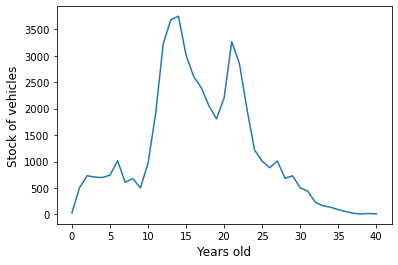

In [3]:
df = pd.read_excel("Turnover logic spreadsheet.xlsx",sheet_name = ['Python_input_data'])
df.keys()
vintage = np.array(df['Python_input_data'].Vintage)
survival = np.array(df['Python_input_data'].Survival_rate)
vehicle_distribution = np.array(df['Python_input_data'].Initial_distribution)
print("Total number of vehicles",vehicle_distribution.sum())
plt.plot(vintage,vehicle_distribution)
plt.xlabel('Years old', size=12)
plt.ylabel('Stock of vehicles', size=12)

In [4]:
df1 = pd.read_excel("Turnover logic spreadsheet.xlsx",sheet_name = ['AB'])
df1.keys()
vehicles_per_1000_people = df1['AB'].Vehicles_per_1000_people
GDP_per_capita = df1['AB'].GDP_per_capita

df2 = pd.read_excel("Turnover logic spreadsheet.xlsx",sheet_name = ['AB_projected'])
df2.keys()
GDP_per_capita_projected = (df2['AB_projected'].GDP_per_capita)*1000
population_projected = (df2['AB_projected'].Population)

In [5]:
a_start = 600.0 #Value taken from Sarkar et al  #
c_start = 0.0002 # Taken from Singh et al; high-income level elasticity factor

m = np.log(pd.to_numeric(vehicles_per_1000_people)/a_start)
n=1/(np.exp(-c_start*pd.to_numeric(GDP_per_capita)))
b_s =np.average(m*n)
b_start = b_s*-1
b_start

7.204624393199166

In [6]:
def gompertz(a, b, c, t): 
    #a= saturation (vehicle/1000 people), b and c = negative parameters, t= GDP per capita
    return a*np.exp(-b*np.exp(-c*t))


y = gompertz(a_start, b_start, c_start,GDP_per_capita_projected) 
projected_vehicle_stocks = y*population_projected
#projected_vehicle_stocks.round(decimals=0)

In [7]:
style={'description_width':'initial'}
@widgets.interact(EV_sales_fraction_2030= FloatSlider(min=0, max=1,step=0.1,continuous_update=False, description ='EV sales fraction 2030',style =style), 
                  EV_sales_fraction_2040=FloatSlider(min=0, max=1,step=0.1,continuous_update=False, description ='EV sales fraction 2040',style=style),
                  EV_sales_fraction_2050=FloatSlider(min=0, max=1,step=0.1,continuous_update=False,description ='EV sales fraction 2050', style=style),
                  sales_oldest_vintage= IntSlider(min=5, max=10,step=1,continuous_update=False, description ='Oldest Vintage sales (in years)', style=style))

def plot(EV_sales_fraction_2030,EV_sales_fraction_2040, EV_sales_fraction_2050, sales_oldest_vintage):
    #Define the function that represents the progression of sales of EVs over time; here it is a three-part function
    #with three input values for 2030, 2040 and 2050 taken from above (again, ideally with sliders)
    sales1 = np.linspace(0,EV_sales_fraction_2030,11)
    sales2 = np.linspace(EV_sales_fraction_2030+(EV_sales_fraction_2040-EV_sales_fraction_2030)/10,EV_sales_fraction_2040,10)
    sales3 = np.linspace(EV_sales_fraction_2040+(EV_sales_fraction_2050-EV_sales_fraction_2040)/10,EV_sales_fraction_2050,10)
    EV_sales_fraction = np.concatenate((sales1,sales2,sales3))
    #Define a vector of years for use later
    years = np.linspace(2020, 2050, 31).astype(int)
    #Initialize the arrays (will be added to by concatenation later)
    EV_sales=[0]
    ICEV_sales=[5000]
    #Define a loop variable to count through the years over which we are interested in running the program.
    x = range(len(years)-1)
    #Assume that initially all vehicles are ICEVs; initialized the array of EV distribution with zeros
    ICEV_distribution = vehicle_distribution
    EV_distribution = [0]*len(vehicle_distribution)
    EV_total = [0]
    ICEV_total = [vehicle_distribution.sum()]
    for i in x:
        #Use the survival profile to "scrap" cars of different vintages with a given probability, both ICEVs and EVs
        ICEV_scrap_by_vintage = (ICEV_distribution*(1-survival)).astype(int)
        EV_scrap_by_vintage = (EV_distribution*(1-survival)).astype(int)
        
        #Here's what's left of each vintage after the scrapping is done each year
        ICEV_remaining_by_vintage = (ICEV_distribution - ICEV_scrap_by_vintage).astype(int)
        EV_remaining_by_vintage = (EV_distribution - EV_scrap_by_vintage).astype(int)
        
        #Total scrappage distribution by vintage
        scrap_by_vintage = ICEV_scrap_by_vintage + EV_scrap_by_vintage
       
        ##Key assumption to start is that total sales is just equal to total scrappage, thus keeping the total number
        #of vehicles constant; can be modified later to allow for growth with the Gompertz function
        #vehicle_sales_total = scrap_by_vintage.sum().round(decimals=0) ## 40405 is stock for year 2019
        #if i==0:
        #    vehicle_sales_total = projected_vehicle_stocks[i].round(decimals=0) - 40405 + scrap_by_vintage.sum()
        #else:
        vehicle_sales_total = projected_vehicle_stocks[i+1].round(decimals=0) - projected_vehicle_stocks[i].round(decimals=0) + scrap_by_vintage.sum()
            
            
        #Count the total sales for EVs and ICEVs each time through the loop
        EV_sales.append(((vehicle_sales_total*EV_sales_fraction[i]).astype(int)).sum())
        ICEV_sales.append(((vehicle_sales_total*(1-EV_sales_fraction[i])).astype(int)).sum())
        
        #Assume a uniform distribution of sales over different vintages; this could be changed, but we don't have
        #particularly good reason to know how the vintage distribution of sold vehicles will look
        sales_by_vintage = vehicle_sales_total/(sales_oldest_vintage+1)
        
        #Divide sales between EVs and ICEVs, and by vintage; 
        #Create an array of sales by vintage for EVs and ICEVsicle_sales_total/(sales_oldest_vintage+1)
        EV_sales_by_vintage = (sales_by_vintage*EV_sales_fraction[i]).round(decimals=0)
        ICEV_sales_by_vintage = (sales_by_vintage*(1-EV_sales_fraction[i])).round(decimals=0)
        EV_sales_vintage_distribution = [EV_sales_by_vintage.round(decimals=0)]*(sales_oldest_vintage+1)+[0]*(len(vehicle_distribution)-(sales_oldest_vintage+1))
        ICEV_sales_vintage_distribution = [ICEV_sales_by_vintage.round(decimals=0)]*(sales_oldest_vintage+1)+[0]*(len(vehicle_distribution)-(sales_oldest_vintage+1))
        
        # Create the new distribution array before going through the loop again
        # Now the cars that were 0 years old will be 1 year old, etc.  The zero-year-old cars in the stock for the next 
        #are that fraction of the sales that were of new cars
        EV_distribution = shift(EV_remaining_by_vintage, 1, cval=0) + EV_sales_vintage_distribution
        ICEV_distribution = shift(ICEV_remaining_by_vintage, 1, cval=0) + ICEV_sales_vintage_distribution
        
        #Continue building the array of EV stock and ICEV stock; will be used for plotting as a function of time.
        EV_total.append(EV_distribution.sum())
        ICEV_total.append(ICEV_distribution.sum())
        #print(population_projected[i])
      
    plt.stackplot(years, [EV_total, ICEV_total])
    plt.legend(['EV Stock', 'ICEV Stock'],fontsize='large',bbox_to_anchor=(1.40, 0.9))
    plt.xlabel('Year', size=12)
    plt.ylabel('Stock of vehicles', size=12)
   

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='EV sales fraction 2030', ma…